## **Pistol detection using tensorflow object detection api**
**credits:https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/supplement/wbql7/eager-few-shot-object-detection**

In [2]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2720, done.
remote: Counting objects: 100% (2720/2720), done.
remote: Compressing objects: 100% (2261/2261), done.
remote: Total 2720 (delta 688), reused 1282 (delta 425), pack-reused 0
Receiving objects: 100% (2720/2720), 32.71 MiB | 31.60 MiB/s, done.
Resolving deltas: 100% (688/688), done.


In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1657639 sha256=616f22eab9060eadbfd572f0ddafbfabcabd19b8a559df40c9fcc98d95ccab95
  Stored in directory: /tmp/pip-ephem-wheel-cache-80r8shso/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=84de52ad4e250e81b2da040676580a527bdd2054c6237dbb250f6fa18c813e4c
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=6926e4affb91defe1fbb77ba877413b65cc985b05d72db8c6072df903f1b9a5b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78545 sha256=54309795393669eaa28ed6906505aa3912b4cec8c30e8b402d63

ERROR: multiprocess 0.70.12.2 has requirement dill>=0.3.4, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.30.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [45]:
import matplotlib.pyplot as plt
import os
import io
import imageio
import random
from six import BytesIO
from PIL import Image
import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util,config_util,colab_utils
from object_detection.utils import visualization_utils as viz_utils 
from object_detection.builders import model_builder

**Helper functions**

In [21]:
def load_image_into_numpy_array(path):
  
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):

  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

**Reading the data**

In [23]:
train_dir="/content/train"
train_images_np=[]
for i in range(1,10):
  image_path=os.path.join(train_dir,'gun'+str(i)+'.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

**Displaying the images**

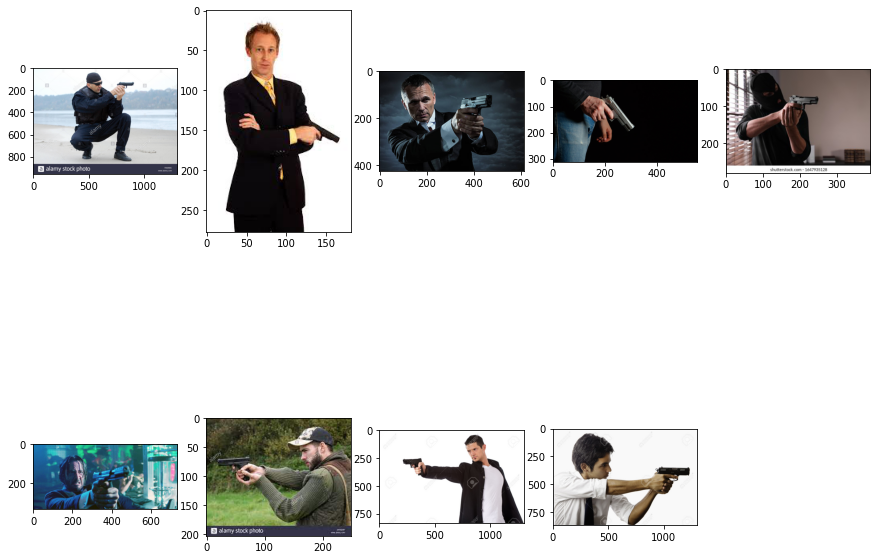

In [35]:
%matplotlib inline
fig=plt.figure(figsize=(15,12))
for idx, train_image_np in enumerate(train_images_np):
  fig.add_subplot(2, 5, idx+1)
  plt.imshow(train_image_np)


**Annotating the images using colab utils**

In [36]:
gt_boxes=[]
colab_utils.annotate(train_images_np,box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [37]:
gun_class_id=1
num_classes=1
category_index={gun_class_id:{"id":gun_class_id,"name":"gun"}}

In [38]:
#converting the images and the boxex into tensors
label_id_offset=1
train_image_tensors=[]
gt_classes_one_hot_tensors=[]
gt_box_tensors=[]
for (train_image_np,gt_box_np) in zip(train_images_np,gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np,dtype=tf.float32),axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np,dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))

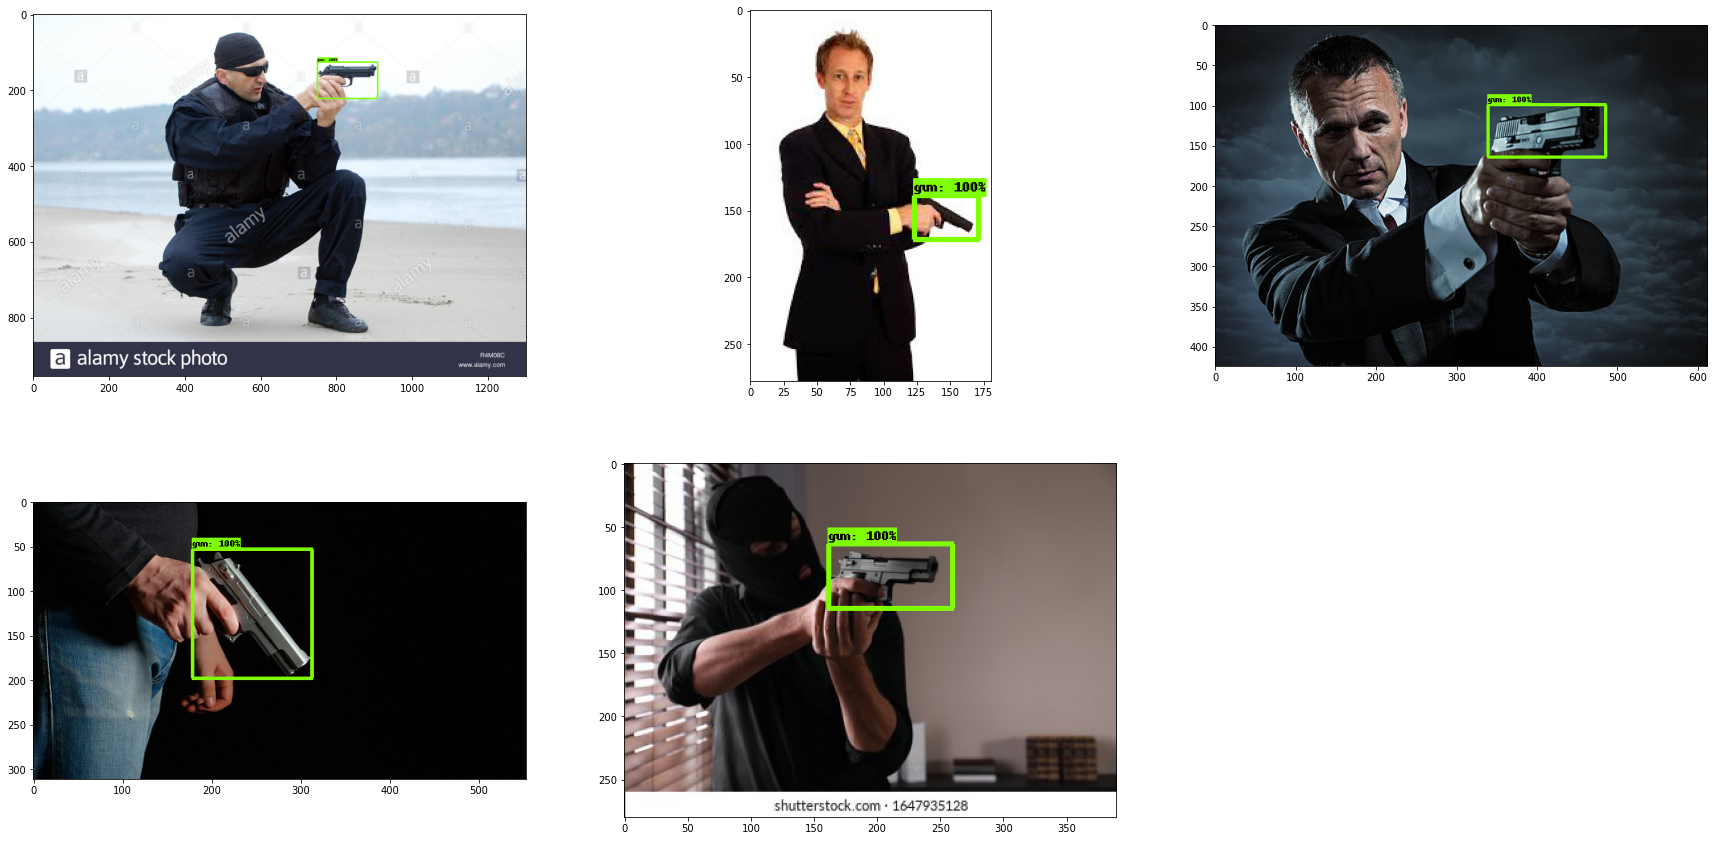

In [41]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

**Downloading the RetinaNet model for object detection**

In [42]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-06-25 13:11:31--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   112MB/s    in 2.1s    

2021-06-25 13:11:33 (112 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



Restoring the weights and buliding the model

In [43]:
num_classes=1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'
configs=config_util.get_configs_from_pipeline_file(pipeline_config)
model_config=configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

Training the model

In [46]:
batch_size = 4
learning_rate = 0.01
num_batches = 100


trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
  
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]


  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)



Start fine-tuning!
batch 0 of 100, loss=1.3576243
batch 10 of 100, loss=0.50271416
batch 20 of 100, loss=0.22798294
batch 30 of 100, loss=0.108710505
batch 40 of 100, loss=0.055015963
batch 50 of 100, loss=0.036824197
batch 60 of 100, loss=0.029107448
batch 70 of 100, loss=0.015657423
batch 80 of 100, loss=0.013374425
batch 90 of 100, loss=0.012490213


**testing the model**

In [52]:
image_path="/content/gun11.jpg"
label_id_offset = 1
test_image=np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0)
@tf.function
def detect(input_tensor):
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)
input_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
detections = detect(input_tensor)

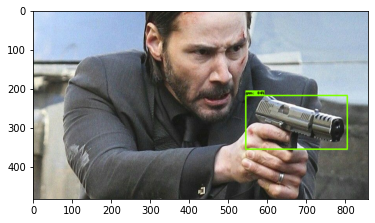

In [55]:
plot_detections(
      test_image[0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(20, 20))